# Описание проекта
Клиентам телеком компании предлагают два тарифных плана: «Смарт» и «Ультра». Необходимо понять, какой тариф приносит больше денег.

Для этого необходимо провести предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание данных

#### Таблица users (информация о пользователях):

user_id — уникальный идентификатор пользователя

first_name — имя пользователя

last_name — фамилия пользователя

age — возраст пользователя (годы)

reg_date — дата подключения тарифа (день, месяц, год)

churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

city — город проживания пользователя

tariff — название тарифного плана


#### Таблица calls (информация о звонках):

id — уникальный номер звонка

call_date — дата звонка

duration — длительность звонка в минутах

user_id — идентификатор пользователя, сделавшего звонок

#### Таблица messages (информация о сообщениях):

id — уникальный номер сообщения

message_date — дата сообщения

user_id — идентификатор пользователя, отправившего сообщение

#### Таблица internet (информация об интернет-сессиях):

id — уникальный номер сессии

mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)

session_date — дата интернет-сессии

user_id — идентификатор пользователя

#### Таблица tariffs (информация о тарифах):

tariff_name — название тарифа

rub_monthly_fee — ежемесячная абонентская плата в рублях

minutes_included — количество минут разговора в месяц, включённых в абонентскую плату

messages_included — количество сообщений в месяц, включённых в абонентскую плату

mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

rub_per_message — стоимость отправки сообщения сверх тарифного пакета

rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


### Шаг 1. Откройте файл с данными и изучите общую информацию


In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt 


df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

In [2]:
display(df_users.head(10))
print('--------------------------')
df_users.info()

display(df_calls.head(10))
print('--------------------------')
df_calls.info()

display(df_internet.head(10))
print('--------------------------')
df_internet.info()

display(df_messages.head(10))
print('--------------------------')
df_messages.info()

display('--------------------------')
print(df_tariffs)

   user_id  age churn_date              city first_name  last_name  \
0     1000   52        NaN         Краснодар     Рафаил  Верещагин   
1     1001   41        NaN            Москва       Иван       Ежов   
2     1002   59        NaN       Стерлитамак    Евгений  Абрамович   
3     1003   23        NaN            Москва      Белла   Белякова   
4     1004   68        NaN       Новокузнецк    Татьяна   Авдеенко   
5     1005   67        NaN  Набережные Челны   Афанасий     Горлов   
6     1006   21        NaN         Ульяновск     Леонид   Ермолаев   
7     1007   65        NaN            Москва        Юна   Березина   
8     1008   63        NaN         Челябинск     Рустэм  Пономарёв   
9     1009   24        NaN             Пермь   Василиса    Блинова   

     reg_date tariff  
0  2018-05-25  ultra  
1  2018-11-01  smart  
2  2018-06-17  smart  
3  2018-08-17  ultra  
4  2018-05-14  ultra  
5  2018-01-25  smart  
6  2018-02-26  smart  
7  2018-04-19  smart  
8  2018-12-19  smart  

####  Для выполнения проекта необходимо ознакомиться с 5 датасетами. Замечено, что столбцы, содержащие даты, имеют неверный формат. Из приятного - отсутствуют пропущенные значения в необходимых для анализа столбцах.  

### Шаг 2. Подготовьте данные


#### Предобработка данных

In [3]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format = '%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y-%m-%d')

df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')

In [4]:
df_calls['duration'] = df_calls['duration'].apply(np.ceil)
df_internet['mb_used'] = df_internet['mb_used'].apply(np.ceil)
df_calls['duration'] = df_calls['duration'].replace(0, 1)

#### Формат столбцов с датами был исправлен. 
#### Значения в столбцах 'duration' и 'mb_used' были округлены до верхнего значения. Сделано это было по причине того, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

#### Также в столбце duration все нулевые значения были изменены на единичку. Это было сделано из предположения, что раз в датафрейме df_calls имеется запись о звонке длительностью 0 минут, то сам звонок всё-таки имел место быть. Сама компания при этом потратила ресурсы на его осуществление.

#### Формирование необходимых таблиц:

#### 1) Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя:


In [5]:
df_calls['month'] = pd.to_datetime(df_calls['call_date']).dt.to_period('M')

calls = df_calls.groupby(['user_id', 'month']).agg({'user_id':'count','duration':'sum'})
calls.columns = ['calls_amount', 'duration']

print(calls.head(10))

                 calls_amount  duration
user_id month                          
1000    2018-05            22     164.0
        2018-06            43     187.0
        2018-07            47     346.0
        2018-08            52     418.0
        2018-09            58     478.0
        2018-10            57     363.0
        2018-11            43     344.0
        2018-12            46     341.0
1001    2018-11            59     444.0
        2018-12            63     430.0


#### 2) Количество отправленных сообщений по месяцам:


In [6]:
df_messages['month'] = pd.to_datetime(df_messages['message_date']).dt.to_period('M')

messages = df_messages.groupby(['user_id', 'month']).agg({'user_id':'count'})
messages.columns = ['total_messages']

print(messages.head(10))

                 total_messages
user_id month                  
1000    2018-05              22
        2018-06              60
        2018-07              75
        2018-08              81
        2018-09              57
        2018-10              73
        2018-11              58
        2018-12              70
1002    2018-06               4
        2018-07              11


#### 3) Объем израсходованного интернет-трафика по месяцам:


In [7]:
df_internet['month'] = pd.to_datetime(df_internet['session_date']).dt.to_period('M')

internet = df_internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'})

print(internet.head(10))

                 mb_used
user_id month           
1000    2018-05   2256.0
        2018-06  23257.0
        2018-07  14016.0
        2018-08  14070.0
        2018-09  14581.0
        2018-10  14717.0
        2018-11  14768.0
        2018-12   9827.0
1001    2018-11  18452.0
        2018-12  14053.0


#### 4) Помесячная выручка с каждого пользователя:

In [8]:
df = calls.merge(internet, on=['user_id', 'month'], how='outer')
df = df.merge(messages, on=['user_id', 'month'], how='outer').reset_index()
df = df.merge(df_users, on='user_id')
print(df.head(15))

    user_id    month  calls_amount  duration  mb_used  total_messages  age  \
0      1000  2018-05          22.0     164.0   2256.0            22.0   52   
1      1000  2018-06          43.0     187.0  23257.0            60.0   52   
2      1000  2018-07          47.0     346.0  14016.0            75.0   52   
3      1000  2018-08          52.0     418.0  14070.0            81.0   52   
4      1000  2018-09          58.0     478.0  14581.0            57.0   52   
5      1000  2018-10          57.0     363.0  14717.0            73.0   52   
6      1000  2018-11          43.0     344.0  14768.0            58.0   52   
7      1000  2018-12          46.0     341.0   9827.0            70.0   52   
8      1001  2018-11          59.0     444.0  18452.0             NaN   41   
9      1001  2018-12          63.0     430.0  14053.0             NaN   41   
10     1002  2018-06          15.0     118.0  10871.0             4.0   59   
11     1002  2018-07          26.0     219.0  17601.0           

In [9]:
df.isna().mean()

user_id           0.000000
month             0.000000
calls_amount      0.012446
duration          0.012446
mb_used           0.003423
total_messages    0.154636
age               0.000000
churn_date        0.941817
city              0.000000
first_name        0.000000
last_name         0.000000
reg_date          0.000000
tariff            0.000000
dtype: float64

In [10]:
df = df.fillna(0)

In [11]:
df.isna().mean()

user_id           0.0
month             0.0
calls_amount      0.0
duration          0.0
mb_used           0.0
total_messages    0.0
age               0.0
churn_date        0.0
city              0.0
first_name        0.0
last_name         0.0
reg_date          0.0
tariff            0.0
dtype: float64

In [12]:
df['gb_used'] = (df['mb_used'] / 1024).apply(np.ceil)

In [13]:
def function(row):
    duration = row['duration']
    messages = row['total_messages']
    gb_used = row['gb_used']
    tariff = row['tariff']
    
    if tariff == 'ultra':
        
        if duration > df_tariffs['minutes_included'].loc[1]:
            duration_diff = duration -  df_tariffs['minutes_included'].loc[1]
        else:
            duration_diff = 0
        
        if gb_used > df_tariffs['mb_per_month_included'].loc[1] / 1024:
            gb_used_diff = gb_used - df_tariffs['mb_per_month_included'].loc[1] / 1024
        else:
            gb_used_diff = 0 
        
        if messages > df_tariffs['messages_included'].loc[1]:
            messages_diff = messages - df_tariffs['messages_included'].loc[1]
        else:
            messages_diff = 0
        
        revenue_ultra = (
                (duration_diff * df_tariffs['rub_per_minute'].loc[1]) 
                + (gb_used_diff * df_tariffs['rub_per_gb'].loc[1]) 
                + (messages_diff * df_tariffs['rub_per_message'].loc[1]) +
                 df_tariffs['rub_monthly_fee'].loc[1]
                )
        return revenue_ultra
            
    else:
        if duration > df_tariffs['minutes_included'].loc[0]:
            duration_diff = duration -  df_tariffs['minutes_included'].loc[0]
        else:
            duration_diff = 0
        
        if gb_used > df_tariffs['mb_per_month_included'].loc[0] / 1024:
            gb_used_diff = gb_used - df_tariffs['mb_per_month_included'].loc[0] / 1024
        else:
            gb_used_diff = 0 
        
        if messages > df_tariffs['messages_included'].loc[0]:
            messages_diff = messages - df_tariffs['messages_included'].loc[0]
        else:
            messages_diff = 0
        
        revenue_smart = (
            (duration_diff * df_tariffs['rub_per_minute'].loc[0]) 
            + (gb_used_diff * df_tariffs['rub_per_gb'].loc[0]) 
            + (messages_diff * df_tariffs['rub_per_message'].loc[0]) +
             df_tariffs['rub_monthly_fee'].loc[0]
            )
        return revenue_smart

In [14]:
df['revenue'] = df.apply(function, axis = 1)

In [15]:
df.sample(10)

,user_id,month,calls_amount,duration,mb_used,total_messages,age,churn_date,city,first_name,last_name,reg_date,tariff,gb_used,revenue
8,1001,2018-11,59.0,444.0,18452.0,0.0,41,0,Москва,Иван,Ежов,2018-11-01,smart,19.0,1350.0
829,1134,2018-02,59.0,473.0,13071.0,47.0,65,0,Красноярск,Марьяна,Авросимова,2018-01-16,smart,13.0,550.0
2038,1325,2018-11,84.0,560.0,27488.0,13.0,63,0,Новосибирск,Артём,Федосеев,2018-06-12,ultra,27.0,1950.0
3163,1496,2018-11,80.0,676.0,25092.0,46.0,36,0,Вологда,Трифон,Блохин,2018-01-27,smart,25.0,3078.0
1781,1285,2018-02,10.0,81.0,645.0,31.0,44,0,Краснодар,Ефим,Амельченко,2018-02-20,smart,1.0,550.0
2992,1470,2018-11,64.0,521.0,20080.0,21.0,23,0,Новокузнецк,Эллада,Лосева,2018-10-19,smart,20.0,1613.0
2450,1388,2018-11,74.0,523.0,24794.0,0.0,24,0,Вологда,Рустам,Левин,2018-08-27,smart,25.0,2619.0
470,1073,2018-12,71.0,542.0,15795.0,27.0,63,0,Владикавказ,Гордей,Павловский,2018-10-04,smart,16.0,876.0
2620,1413,2018-08,10.0,66.0,8771.0,3.0,37,0,Новосибирск,Леон,Фролов,2018-08-19,smart,9.0,550.0
1382,1219,2018-06,63.0,465.0,17732.0,8.0,75,0,Киров,Кузьма,Некрасов,2018-01-21,smart,18.0,1150.0


#### После того, как посчитали для каждого пользователя количество сделанных звонков, потраченных минут разговора, количество отправленных смс и израсходаванного интернет-трафика,  все таблицы в собрали в единую.
После этого необходимо было проверить сводную таблицу на наличие пустых значений. Всех их заменили на 0, так как они (пустые значения) свидетельствуют о том, что в конкретный месяц конкретным пользователем не было совершено звонка/отправлено смс/израсходавано трафика. 

В таблицу также был добавлен столбец 'gb_used' - в нем переведенные в гигабайты значения столбца 'mb_used'. Сделано было для удобства расчета выручки. 

<div class="alert alert-block alert-success">
Теперь у нас есть сводная таблица, по которой мы можем провести дальнейший анализ. Посмотрим, что получилось.

p.s.: здорово, что ты поясняешь свои действия
</div>
    
---

### Шаг 3. Проанализируйте данные

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.


In [16]:
df[df['tariff'] == 'smart'][['duration', 'gb_used', 'total_messages']].describe()

,duration,gb_used,total_messages
count,2229.000000,2229.000000,2229.000000
mean,429.450875,16.359354,33.384029
std,194.871174,5.758498,28.227876
min,0.000000,0.000000,0.000000
25%,291.000000,13.000000,10.000000
50%,435.000000,17.000000,28.000000
75%,560.000000,20.000000,51.000000
max,1471.000000,38.000000,143.000000


In [17]:
df[df['tariff'] == 'ultra'][['duration', 'gb_used', 'total_messages']].describe()

,duration,gb_used,total_messages
count,985.000000,985.000000,985.000000
mean,540.779695,19.525888,49.363452
std,325.738740,9.865848,47.804457
min,0.000000,0.000000,0.000000
25%,292.000000,12.000000,6.000000
50%,532.000000,19.000000,38.000000
75%,773.000000,27.000000,79.000000
max,1727.000000,49.000000,224.000000


#### Средние значения всех исследуемых параметров у тарифа ultra выше, чем у тарифа smart. В этом ничего удивительного, так как этот тариф изначально предлагает больше ресурсов для пользователей. 

#### Стандартное отклонение так же выше по все пунктам по сравнению с тарифом smart, что тоже неудивительно. Пользователям предлагается больше бесплатных ресурсов для использования, поэтому "размах" потенциального использования ресурсами шире. К примеру,пользавателю smart доступно 15 ГБ трафика, и он, стараясь не выходить за рамки, тратит от 0 до 15 ГБ в месяц, в то время как пользователь ultra свободно тратит от 0 до 30 ГБ в месяц. 

<div class="alert alert-block alert-success">
Всё верно. Наглядный вывод информации для сравнения
</div>
    
---

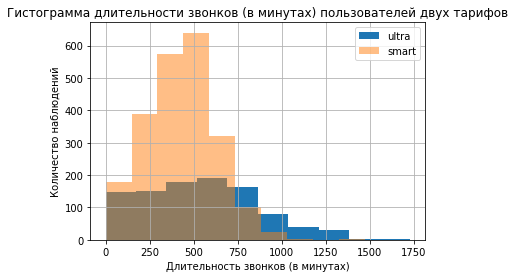

In [18]:
df[df['tariff'] == 'ultra']['duration'].hist(alpha = 1, label = 'ultra')
df[df['tariff'] == 'smart']['duration'].hist(alpha = 0.5, label = 'smart')
plt.title('Гистограмма длительности звонков (в минутах) пользователей двух тарифов')
plt.xlabel('Длительность звонков (в минутах)')
plt.ylabel('Количество наблюдений')
plt.legend()


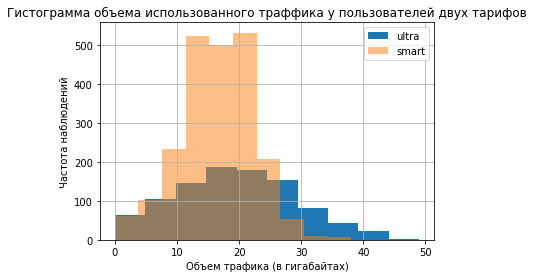

In [19]:
df[df['tariff'] == 'ultra']['gb_used'].hist(alpha = 1, label = 'ultra')
df[df['tariff'] == 'smart']['gb_used'].hist(alpha = 0.5, label = 'smart')
plt.title('Гистограмма объема использованного траффика у пользователей двух тарифов')
plt.xlabel('Объем трафика (в гигабайтах)')
plt.ylabel('Частота наблюдений')
plt.legend()



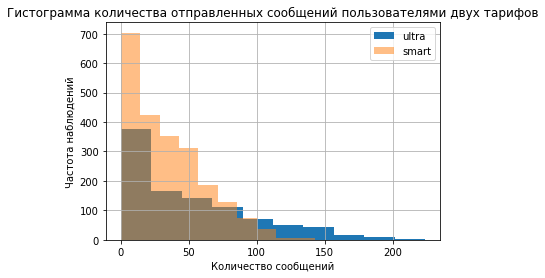

In [20]:
df[df['tariff'] == 'ultra']['total_messages'].hist(alpha = 1, label = 'ultra')
df[df['tariff'] == 'smart']['total_messages'].hist(alpha = 0.5, label = 'smart')
plt.title('Гистограмма количества отправленных сообщений пользователями двух тарифов')
plt.xlabel('Количество сообщений')
plt.ylabel('Частота наблюдений')
plt.legend()

#### Распределения гистограмм не отличаются в зависимости от тарифа. Гистограммы по тарифу smart "выше", чем гистограммы по тарифу ultra, так как изначально выборка пользователей с тарифом smart превышает выборку пользователей с тарифом ultra. 
#### Длительность звонков и объема использованного траффика имеют нормальное распределение. Количество отправленных сообщений тоже имеет нормальное распределение, но оно скошенно вправо.

### Шаг 4. Проверьте гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

----------------------------------------------------------------------------------------------------------------------
**Гипотеза H0**: Средняя выручка пользователей тарифов 'ultra' равна средней выручке пользователей тарифа 'smart'

**Гипотеза H1**: Средняя выручка пользователей тарифов 'ultra' не равна средней выручке пользователей тарифа 'smart'

In [21]:
print('Дисперсия выручки пользователей тарифа smart', df[df['tariff'] == 'smart']['revenue'].var())
print('Дисперсия выручки пользователей тарифа ultra', df[df['tariff'] == 'ultra']['revenue'].var())

Дисперсия выручки пользователей тарифа smart 688973.8957511279
Дисперсия выручки пользователей тарифа ultra 143491.24055961374


In [22]:
alpha = .05

results = st.ttest_ind(
    df[df['tariff'] == 'smart']['revenue'],
    df[df['tariff'] == 'ultra']['revenue'],
    equal_var = False) # так как дисперсия датасетов сильно отличается, указываем equal_var = False. 


print('p-значение:', results.pvalue)

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print()
print('Средняя выручка пользователей тарифа smart', df[df['tariff'] == 'smart']['revenue'].mean())
print('Средняя выручка пользователей тарифа ultra', df[df['tariff'] == 'ultra']['revenue'].mean())

p-значение: 2.2071398635388928e-234
Отвергаем нулевую гипотезу

Средняя выручка пользователей тарифа smart 1311.615074024226
Средняя выручка пользователей тарифа ultra 2071.0659898477156


#### Гипотеза о равенстве средней выручки двух тарифов отклонена. Более того, приняв во внимание рассчитанные средние выручки двух тарифов, можно утверждать, что средняя выручка пользователей тарифа ultra превышает выручку от пользователей тарифа smart



-----------------------------------------------------------------------------------------------------------------------------
**Гипотеза H0**: Средняя выручка пользователей из Москвы равна выручке пользователей других регионов

**Гипотеза H1**: Средняя выручка пользователей из Москвы не равна выручке пользователей других регионов

In [23]:
print('Дисперсия выручки пользователей из Москвы', df[df['city'] == 'Москва']['revenue'].var())
print('Дисперсия выручки пользователей других регионов', df[df['tariff'] != 'Москва']['revenue'].var())

Дисперсия выручки пользователей из Москвы 568264.3968286335
Дисперсия выручки пользователей других регионов 644330.0682119215


In [24]:
alpha = .05

results = st.ttest_ind(
    df[df['city'] == 'Москва']['revenue'],
    df[df['city'] != 'Москва']['revenue'],
    equal_var = True) # дисперсии не сильно отличаются между собой => equal_var = True


print('p-значение:', results.pvalue)

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print()
print('Средняя выручка пользователей из Москвы', df[df['city'] == 'Москва']['revenue'].mean())
print('Средняя выручка пользователей других регионов', df[df['city'] != 'Москва']['revenue'].mean())

p-значение: 0.5794098792001428
Не получилось отвергнуть нулевую гипотезу

Средняя выручка пользователей из Москвы 1560.5662847790506
Средняя выручка пользователей других регионов 1540.5624279677295


#### Гипотезу о том, что средняя выручка пользователей из Москвы равна выручке пользователей из других регионов, отвегнуть не получилось. Рассчитанные средние выручки пользователей из Москвы и других регионов так же свидетельствуют о том, что они почти одинаковые.

### *Какой тариф лучше?*

In [25]:
print('Количество пользователей тарифа Ультра', len(df[df['tariff'] == 'ultra']))
print('Количество пользователей тарифа Смарт', len(df[df['tariff'] == 'smart']))

Количество пользователей тарифа Ультра 985
Количество пользователей тарифа Смарт 2229


In [26]:
print('Суммарная выручка от пользователей тарифа Ультра', 
      df[df['tariff'] == 'ultra']['revenue'].mean() * len(df[df['tariff'] == 'ultra']))
print('Суммарная выручка от пользователей тарифа Смарт', 
      df[df['tariff'] == 'smart']['revenue'].mean() * len(df[df['tariff'] == 'smart']))

Суммарная выручка от пользователей тарифа Ультра 2040000.0
Суммарная выручка от пользователей тарифа Смарт 2923590.0


#### Можно заметить, что количество пользователей тарифа Смарт в 2 раза больше, чем пользователей тарифа Ультра. 

#### Выручка от пользователей тарифа Смарт превышает выручку от пользователей тарифа Ультра примерно в 1,5 раза.

### Шаг 5. Общий вывод

На первом шаге работы были изучены 5 датафреймов и изучены данные, содержащиеся в них. 

-------------------------------------------------------------------------------------------------------------------
Далее была проведена предобработка данных, в частности изменены форматы столбцов, содержащие в себе даты. 
Значения столбцов, в которых отражалось длительность звонков, объем использованного трафика были округлены вверх. Это было сделано для верного расчета выручки, ведь пользователи платят за 1 секунду разговора как за полную минуту. 
Нулевые значения длительности звонков были заменены на единицу. Это было сделано из предположения, что раз в датафрейме df_calls имеется запись о звонке длительностью 0 минут, то сам звонок всё-таки имел место быть. Сама компания при этом потратила ресурсы на его осуществление. 

---------------------------------------------------------------------------------------------------------------------------------

Для каждого пользователя были подсчитаны:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячная выручка

----------------------------------------
Был проведен анализ средней длительности звонка, использованного траффика и количества сообщений, а также их СКО.  
Средние и среднеквардатическое отклонение всех исследуемых показателей выше у пользователей тарифа **Ультра**. Этот тариф изначально рассчитан на пользователей, которые потребляют больше ресурсов, поэтому результат вполне ожидаемый.

Построенные гистограммы по вышеперечисленным параметрам имеют нормальное распределение. Между пользователями **Смарт** и **Ультра** нет принципиальной разницы в поведении. Заметно, что пользователи тарифа **Ультра** в среднем используют имеющиеся ресурсы больше, чем пользователи тарифа **Смарт**, что вполне закономерно.

-----------
В финальной части работы было проверены две гипотезы:

1) средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

2) средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для проверок был использован метод **ttest_ind**, так как проверялось равенство средних двух генеральных совокупностей


Средняя выручка пользователей тарифов Ультра и Смарт действительно различается, можно даже утверждать, что не просто различаются, а выручка от пользователей Ультра превышает выручку от пользователей Смарт. 

Вторая гипотеза была отвергнута. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.


---------------------------------

*Какой тариф лучше?*

Если исходить из средней выручки от пользователя, то тариф Ультра лучше, так как приносит больше денег - это было потверждено при проверке гипотезы. Однако это совершенно бессмысленно, ведь пользователь тарифа **Ультра** по умолчанию платит гораздо больше денег, чем пользователь тарифа **Смарт** (абонентская плата тарифа **Ультра** составляет 1950 рублей против 550 рублей по тарифу **Смарт**)

Пользователей тарифа **Смарт** в наблюдаемой выборке более чем в два больше по сравнению с количеством пользователей тарифа **Ультра**. Если данное соотношение наблюдается и по всем абонентам компании, то тариф **Смарт** является лучше, так как большое количество пользователей компенсируют меньшую абонентскую плату, и, таким образом, тариф приносит больший доход относительно тарифа **Ультра**

